Суть проекта:
Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 
Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.
И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 


In [ ]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud_math = pd.read_csv('stud_math.xls')#считаем исходные данные 

In [181]:
stud_math.shape#определим размеры датасета

(395, 30)

In [182]:
#Рассмотрим, какие данные хранятся в файле, какие типы данных в столбцах:
display(stud_math.head(10))
stud_math.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [183]:
#выберем столбцы с пропусками, поймем есть ли такие, где пропусков свыше 40% (Их следует удалить)
null_data = stud_math.isnull().sum()
print(null_data[null_data>0])
col_for_drop = [col for col in stud_math.columns if stud_math[col].isnull().sum()>stud_math[col].shape[0]*0.4]
print('Столбцов с пропусками', null_data[null_data>0].shape[0], 'Список столбцов с пропусками свыше 40%', col_for_drop)

address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64
Столбцов с пропусками 27 Список столбцов с пропусками свыше 40% []


Вывод: удалять полностью ни один столбец  из-за пропусков не нужно.
Большинство столбцов содержит пропуски, удалять такие строки не следует из-за небольшого объема датасета, 
нужно будет заменить пропуски. Также при наличии выбросов следует заменять значения, а не удалять строки.

In [184]:
stud_math.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [251]:
#все столбцы имеют пригодные для pandas заголовки, кроме 'studytime, granular', переименуем его
stud_math.columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score']
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [185]:
#функция для расчета границ выбросов и визуализации распределения (для применения к  столбцам с числовыми данными).
def outliers_hist (data, col):
    
    
    IQR = data.loc[:, col].quantile(0.75) - data.loc[:, col].quantile(0.25)
    perc25 = data.loc[:, col].quantile(0.25)
    perc75 = data.loc[:, col].quantile(0.75)
 

    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    
    data.loc[:, col].hist()  
 


In [186]:
#функция для замены нулевых значений на медиану столбца
def median_null_replace(data, col):
    new_col_name = col + '_was_missing'
    data.loc[:, [new_col_name]] = data.loc[:, col].isnull() 
    #зафиксировали в новом столбце значение True по строкам, где будет сделана замена нулевых значений.
    data.loc[:, col] = data.loc[:, col].fillna(data.loc[:, col].median())#заменили нулевые/пустые значения на медиану

In [187]:
#функция для замены нулевых значений на моду столбца
def mode_null_replace(data, col):
    new_col_name = col + '_was_missing'
    data.loc[:, [new_col_name]] = data.loc[:, col].isnull()  
    #зафиксировали в новом столбце значение True по строкам, где будет сделана замена нулевых значений.
    data.loc[:, col] = data.loc[:, col].fillna(data.loc[:, col].mode()[0])#заменили нулевые/пустые значения на моду
   

# 'school' аббревиатура школы, в которой учится ученик

In [188]:
pd.DataFrame(stud_math.school.value_counts())

,school
GP,349
MS,46


In [ ]:
#Пропусков  в столбце нет, строковые данные без дефектов/лишних знаков/опечаток

# 'sex'пол ученика ('F' - женский, 'M' - мужской)

In [189]:
pd.DataFrame(stud_math.sex.value_counts())

,sex
F,208
M,187


In [ ]:
#Пропусков  в столбце нет, строковые данные без дефектов/лишних знаков/опечаток

# 'age' возраст ученика (от 15 до 22)

In [190]:
stud_math.age.unique()

array([18, 17, 15, 16, 19, 22, 20, 21], dtype=int64)

#Пропусков в данных нет, возраст указан в виде целых чисел в границах от 15 до 22 лет (нет противоречий здравому смыслу)

In [191]:
stud_math.age.describe()

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


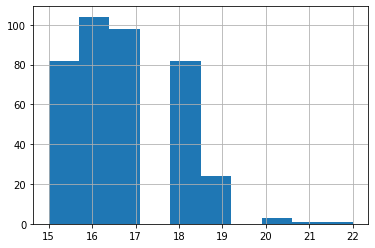

In [192]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math,'age')

In [ ]:
Основная масса учеников в датасете - в возрасте 15-17 лет, учеников старше 18 небольшое количество. 
Расчет показывает границы выбросов 13 (таких учеников у нас в выборке нет) и 21 (согласно условиям исследования
учеников отбирали в возрасте 15-22 лет, с точки зрения смысла исследования 22 выбросом не является).
Столбец не требует дополнительной обработки.

# 'address' тип адреса ученика ('U' - городской, 'R' - за городом)

In [193]:
pd.DataFrame(stud_math.address.value_counts())

,address
U,295
R,83


In [ ]:
#Имеются 17 пропусков данных, строковые данные без дефектов/лишних знаков/опечаток

In [194]:
stud_math.address.unique()

array(['U', nan, 'R'], dtype=object)

In [ ]:
#пустые строки в столбце заменим на часто встречающееся значение 'U'/моду
#заменять будем, скопировав датафрейм, в дополнительных столбцах фиксируя строки, где была сделана замена пропусков

In [253]:
stud_math_plus_data=stud_math.copy()
mode_null_replace(stud_math_plus_data, 'address')

In [254]:
pd.DataFrame(stud_math_plus_data.address.value_counts())

,address
U,312
R,83


In [255]:
stud_math_plus_data.address_was_missing.value_counts()

False    378
True      17
Name: address_was_missing, dtype: int64

# 'famsize' размер семьи('LE3' <= 3, 'GT3' >3)

In [256]:
pd.DataFrame(stud_math_plus_data.famsize.value_counts())

,famsize
GT3,261
LE3,107


In [257]:
stud_math_plus_data.famsize.unique()

array([nan, 'GT3', 'LE3'], dtype=object)

In [258]:
mode_null_replace(stud_math_plus_data, 'famsize')

# 'Pstatus' статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [259]:
pd.DataFrame(stud_math_plus_data.Pstatus.value_counts())

,Pstatus
T,314
A,36


In [ ]:
#было зафиксировано 45 пропусков

In [260]:
stud_math_plus_data.Pstatus.unique()

array(['A', nan, 'T'], dtype=object)

In [261]:
mode_null_replace(stud_math_plus_data, 'Pstatus')

# 'Medu' образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [ ]:
#было зафиксировано 3 пропуска в данных

In [262]:
stud_math_plus_data.Medu.unique()

array([ 4.,  1.,  3.,  2., nan,  0.])

In [263]:
#данные имеют вид чисел, приведем столбец к числовому формату
stud_math_plus_data.Medu=stud_math_plus_data.Medu.astype(float)

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


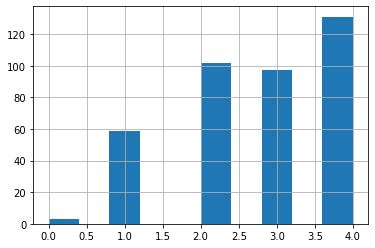

In [264]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math_plus_data,'Medu')

In [206]:
stud_math_plus_data.Medu.describe()

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

Данные лежат в диапазоне от 0 до 4, нетипичных для показателя значений нет (выбросов нет). Свыше 25% родителей имеют высшее образование

In [265]:
#для замены пропусков используем медиану, т.к. значения ниже модального здесь повторяются суммарно существенно чаще моды, 
#медиана тоже ниже моды (моду брать не следует)
median_null_replace(stud_math_plus_data, 'Medu')


#заменив пропуски, можем перевести данные в формат int для ускорения дальнейшей обработки,смысл показателя не требует float 
stud_math_plus_data.Medu=stud_math_plus_data.Medu.astype(int)

# 'Fedu' образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [ ]:
#было зафиксировано 26 пропусков

In [266]:
stud_math_plus_data.Fedu.unique()

array([ 4.,  1.,  2.,  3., 40., nan,  0.])

In [ ]:
#здесь данные сразу в формате float

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


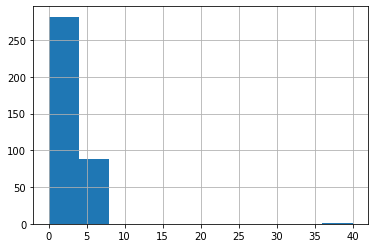

In [210]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math_plus_data,'Fedu')

In [ ]:
Данные имеют выбросы (как отосительно расчетных границ, так и с точки зрения сути показателя - группы по уровню образования 
пронумерованы четко от 0 до 4)

In [211]:
stud_math_plus_data.Fedu.describe()

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

In [212]:
stud_math_plus_data.Fedu[stud_math_plus_data.Fedu>4]

11    40.0
Name: Fedu, dtype: float64

In [267]:
#значение- выброс всего одно и весьма вероятно это опечатка: 40 вместо 4. Заменим выброс.
stud_math_plus_data.Fedu.replace(40.0,4.0,inplace=True)


<AxesSubplot:>

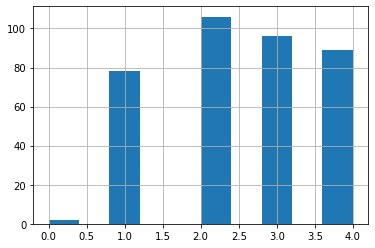

In [214]:
stud_math_plus_data.Fedu.hist()

In [268]:
#для замены пропусков используем медиану, она здесь равна моде
median_null_replace(stud_math_plus_data, 'Fedu')
#заменив пропуски, можем перевести данные в формат int для ускорения дальнейшей обработки,смысл показателя не требует float 
stud_math_plus_data.Fedu=stud_math_plus_data.Fedu.astype(int)

# Mjob' работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [ ]:
#выявлено 19 нулевых значений

In [46]:
pd.DataFrame(stud_math_plus_data.Mjob.value_counts())

,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


In [47]:
stud_math_plus_data.Mjob.unique()

array(['at_home', 'health', 'other', 'services', 'teacher', nan],
      dtype=object)

In [ ]:
#опечаток, дефектов нет, заменим пустые строки на моду

In [269]:
mode_null_replace(stud_math_plus_data, 'Mjob')

# 'Fjob' работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [ ]:
#выявлено 36 нулевых значений

In [49]:
pd.DataFrame(stud_math_plus_data.Fjob.value_counts())

,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


In [50]:
stud_math_plus_data.Fjob.unique()

array(['teacher', 'other', nan, 'health', 'services', 'at_home'],
      dtype=object)

In [270]:
#заменим пустые строки на моду
mode_null_replace(stud_math_plus_data, 'Fjob')

# 'reason' причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [222]:
pd.DataFrame(stud_math_plus_data.reason.value_counts())

,reason
course,137
home,104
reputation,103
other,34


In [53]:
stud_math_plus_data.reason.unique()

array(['course', 'other', 'home', 'reputation', nan], dtype=object)

In [ ]:
#выявлено 17 пропусков, заменим их на моду

In [271]:
mode_null_replace(stud_math_plus_data, 'reason')

# 'guardian' опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [55]:
pd.DataFrame(stud_math_plus_data.guardian.value_counts())

,guardian
mother,250
father,86
other,28


In [ ]:
#выявлен 31 пропуск

In [56]:
stud_math_plus_data.guardian.unique()

array(['mother', 'father', 'other', nan], dtype=object)

In [272]:
#заменим пустые строки на моду
mode_null_replace(stud_math_plus_data, 'guardian')

# 'traveltime' время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [ ]:
#выявлено 28 пропусков

In [58]:
stud_math_plus_data.traveltime.unique()

array([ 2.,  1.,  3., nan,  4.])

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


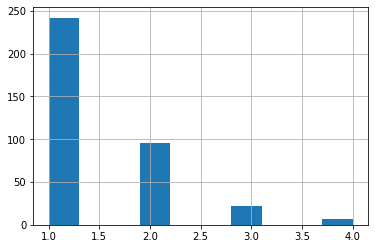

In [59]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math_plus_data,'traveltime')

In [60]:
stud_math_plus_data.traveltime.describe()

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

In [ ]:
#выбросов нет, все данные сответсвтуют логике показателя (0-4)

In [273]:
#для замены пропусков используем медиану, она здесь равна моде
median_null_replace(stud_math_plus_data, 'traveltime')


#заменив пропуски, можем перевести данные в формат int для ускорения дальнейшей обработки,смысл показателя не требует float 
stud_math_plus_data.traveltime=stud_math_plus_data.traveltime.astype(int)

In [230]:
stud_math_plus_data.traveltime.unique()

array([2, 1, 3, 4])

# 'studytime'время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [ ]:
#выявлено 7 пропусков

In [63]:
stud_math_plus_data.studytime.unique()

array([ 2.,  3.,  1., nan,  4.])

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


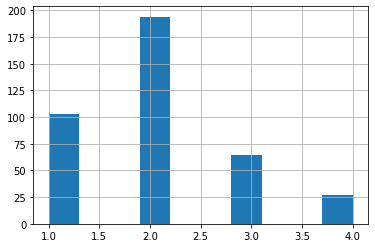

In [64]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math_plus_data,'studytime')

In [ ]:
#выбросов нет, все данные сответсвтуют логике показателя (0-4)

In [65]:
stud_math_plus_data.studytime.describe()

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

In [274]:
#для замены пропусков используем медиану, она здесь равна моде
median_null_replace(stud_math_plus_data, 'studytime')


#заменив пропуски, можем перевести данные в формат int для ускорения дальнейшей обработки,смысл показателя не требует float 
stud_math_plus_data.studytime=stud_math_plus_data.studytime.astype(int)

# 'failures'количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [ ]:
#выявлено 22 пропуска

In [67]:
stud_math_plus_data.failures.unique()

array([ 0.,  3., nan,  2.,  1.])

In [68]:
stud_math_plus_data.failures.describe()

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


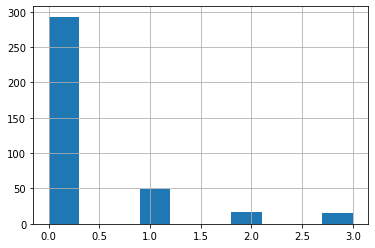

In [69]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math_plus_data,'failures')

In [ ]:
#выбросов нет, все данные сответсвтуют логике показателя (0-3)


In [275]:
#для замены пропусков используем медиану, она здесь равна моде
median_null_replace(stud_math_plus_data, 'failures')


#заменив пропуски, можем перевести данные в формат int для ускорения дальнейшей обработки,смысл показателя не требует float 
stud_math_plus_data.failures=stud_math_plus_data.failures.astype(int)

# 'schoolsup' дополнительная образовательная поддержка (yes или no)

In [ ]:
#выявлено 7 пропусков

In [96]:
stud_math_plus_data.schoolsup.unique()

array(['yes', 'no', nan], dtype=object)

In [97]:
pd.DataFrame(stud_math_plus_data.schoolsup.value_counts())

,schoolsup
no,335
yes,51


In [ ]:
#данные не содержат опеаток, ошибок,...

In [276]:
#заменим пропуски на моду
mode_null_replace(stud_math_plus_data, 'schoolsup')


# 'famsup' семейная образовательная поддержка (yes или no)

In [ ]:
#выявлено 39 нулевых значений

In [100]:
pd.DataFrame(stud_math_plus_data.famsup.value_counts())

,famsup
yes,219
no,137


In [277]:
#заменим пропуски на моду
mode_null_replace(stud_math_plus_data, 'famsup')


# 'paid' дополнительные платные занятия по математике (yes или no)

In [ ]:
#выявлено 40 нулевых значений

In [130]:
stud_math_plus_data.paid.unique()

array(['no', nan, 'yes'], dtype=object)

In [131]:
pd.DataFrame(stud_math_plus_data.paid.value_counts())

,paid
no,200
yes,155


In [278]:
#заменим на моду пропуски
mode_null_replace(stud_math_plus_data, 'paid')


# 'activities' дополнительные внеучебные занятия (yes или no)

In [ ]:
#выявлено 14 пропусков

In [143]:
stud_math_plus_data.activities.unique()

array(['no', 'yes', nan], dtype=object)

In [144]:
pd.DataFrame(stud_math_plus_data.activities.value_counts())

,activities
yes,195
no,186


In [279]:
#заменим на моду пропуски
mode_null_replace(stud_math_plus_data, 'activities')


# 'nursery' посещал детский сад (yes или no)

In [ ]:
#выявлено 16 пропусков

In [147]:
stud_math_plus_data.nursery.unique()

array(['yes', 'no', nan], dtype=object)

In [148]:
pd.DataFrame(stud_math_plus_data.nursery.value_counts())

,nursery
yes,300
no,79


In [280]:
#заменим на моду пропуски
mode_null_replace(stud_math_plus_data, 'nursery')


# 'studytime_granular'

In [ ]:
#было выявлено 7 пропусков

In [281]:
stud_math_plus_data.studytime_granular.unique()

array([ -6.,  -9.,  -3.,  nan, -12.])

In [283]:
#не ясно смысловое содержание колонки, посмотрим на данные, судя по наименованию столюец может быть связан 
#со столбцом studytime 
stud_math_plus_data.head(50)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score,address_was_missing,famsize_was_missing,Pstatus_was_missing,Medu_was_missing,Fedu_was_missing,Mjob_was_missing,Fjob_was_missing,reason_was_missing,guardian_was_missing,traveltime_was_missing,studytime_was_missing,failures_was_missing,schoolsup_was_missing,famsup_was_missing,paid_was_missing,activities_was_missing,nursery_was_missing
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,no,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,GP,F,15,U,GT3,T,4,2,health,other,home,mother,1,3,0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
#при просмотре строк предполагаем, что данные в 'studytime_granular' получены умножением параметра studytime на -3.
#Проверим зависмость между показателями с  помощью графика

<AxesSubplot:title={'center':'studytime_granular Vs studytime'}, xlabel='studytime_granular', ylabel='studytime'>

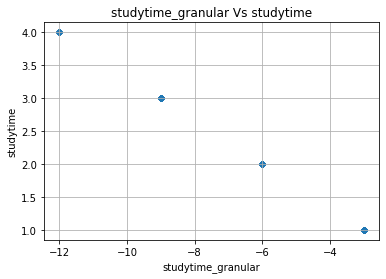

In [285]:
stud_math_plus_data.plot(x = 'studytime_granular', 
                         y = 'studytime', 
                         kind = 'scatter', 
                         grid = True, 
                         title = 'studytime_granular Vs studytime')


In [ ]:
#График  подтверждает линейную зависимость между показателями. Для целей дальнейшего прогнозирования score следует взять 
#один из двух взаимосвязанных факторов, второй удалить. Удалим столбец studytime_granular, т.к. studytime является исходным.

In [287]:
stud_math_reduced_data=stud_math_plus_data.drop('studytime_granular', axis=1)

In [288]:
stud_math_reduced_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,address_was_missing,famsize_was_missing,Pstatus_was_missing,Medu_was_missing,Fedu_was_missing,Mjob_was_missing,Fjob_was_missing,reason_was_missing,guardian_was_missing,traveltime_was_missing,studytime_was_missing,failures_was_missing,schoolsup_was_missing,famsup_was_missing,paid_was_missing,activities_was_missing,nursery_was_missing
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,no,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,GP,F,15,U,GT3,T,4,2,health,other,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# 'higher' хочет получить высшее образование (yes или no)

In [ ]:
#выявлено 20 пропусков

In [289]:
pd.DataFrame(stud_math_reduced_data.higher.value_counts())

,higher
yes,356
no,19


In [290]:
stud_math_reduced_data.higher.unique()

array(['yes', nan, 'no'], dtype=object)

In [291]:
#заменим на моду пропуски
mode_null_replace(stud_math_reduced_data, 'higher')

# 'internet' наличие интернета дома (yes или no)

In [ ]:
#выявлено 34 пропуска

In [292]:
pd.DataFrame(stud_math_reduced_data.internet.value_counts())

,internet
yes,305
no,56


In [294]:
stud_math_reduced_data.internet.unique()

array([nan, 'yes', 'no'], dtype=object)

In [295]:
#заменим на моду пропуски
mode_null_replace(stud_math_reduced_data, 'internet')

# 'romantic' в романтических отношениях (yes или no)

In [ ]:
#выявлено 34 пропуска

In [296]:
pd.DataFrame(stud_math_reduced_data.romantic.value_counts())

,romantic
no,240
yes,124


In [297]:
stud_math_reduced_data.romantic.unique()

array(['no', nan, 'yes'], dtype=object)

In [298]:
#заменим на моду пропуски
mode_null_replace(stud_math_reduced_data, 'romantic')

# 'famrel' семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [ ]:
#выявлено 27 пропусков

In [299]:
stud_math_reduced_data.famrel.unique()

array([ 4.,  5.,  3., nan, -1.,  2.,  1.])

In [301]:
stud_math_reduced_data.famrel.describe()

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


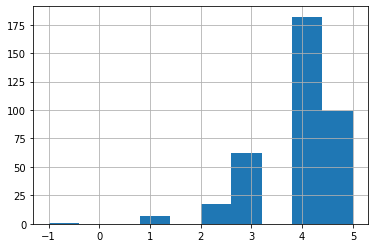

In [302]:
#посмотрим на распределение данных и расчетные границы выбросов
outliers_hist(stud_math_reduced_data,'famrel')

In [305]:
stud_math_reduced_data.famrel[stud_math_reduced_data.famrel==-1]

25   -1.0
Name: famrel, dtype: float64

In [ ]:
#значение -1 является единственным, выходящим за рамки интервала значений 1-5 указанного в описании показателя.
#только его мы заменим как выброс. Варианты замены: на 1 (если предположить что это опечатка), на моду, 
#которая здесь совпадает с медианой. Значение 1 будет единственнм в датасете (что странно), 
#оно выходит и за пределы границ выбросов.  Заменим на моду:

In [306]:
stud_math_reduced_data.famrel.replace(-1.0,4.0, inplace=True)

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


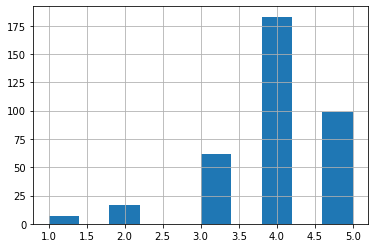

In [307]:
outliers_hist(stud_math_reduced_data,'famrel')

In [313]:
stud_math_reduced_data.famrel=stud_math_reduced_data.famrel.astype(int)

In [315]:
stud_math_reduced_data.famrel.unique()

array([4, 5, 3, 2, 1])

# 'freetime' свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [ ]:
#выявлено 9 пропусков

In [312]:
stud_math_reduced_data.freetime.unique()

array([ 3.,  2.,  4.,  1.,  5., nan])

In [316]:
stud_math_reduced_data.freetime.describe()

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


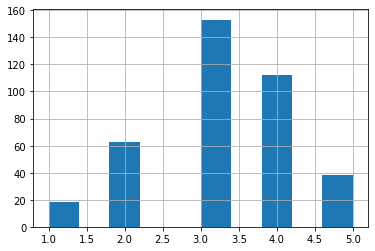

In [318]:
outliers_hist(stud_math_reduced_data,'freetime')

In [ ]:
# все значения  ри 1 до 5 соответствуют логике показателя, выбросов нет

In [320]:
#заменим на моду пропуски
mode_null_replace(stud_math_reduced_data, 'freetime')

In [321]:
#приведем  типу int в соответсвтии со смыслом показателя
stud_math_reduced_data.freetime=stud_math_reduced_data.freetime.astype(int)

# 'goout' проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [322]:
stud_math_reduced_data.freetime.unique()

array([3, 2, 4, 1, 5])

In [323]:
stud_math_reduced_data.goout.describe()

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


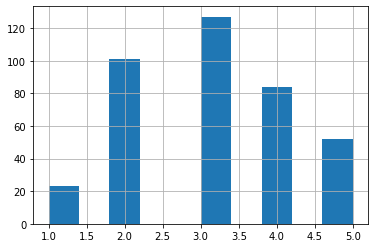

In [324]:
outliers_hist(stud_math_reduced_data,'goout')

In [ ]:
#выбросов нет 

In [393]:
#заменим на моду пропуски (мода равна медиане)
mode_null_replace(stud_math_reduced_data, 'goout')

In [394]:
#приведем  типу int в соответсвтии со смыслом показателя
stud_math_reduced_data.goout=stud_math_reduced_data.goout.astype(int)

# 'health' текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [325]:
stud_math_reduced_data.health.unique()

array([ 3.,  5.,  1.,  2.,  4., nan])

In [362]:
stud_math_reduced_data.health.describe()

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


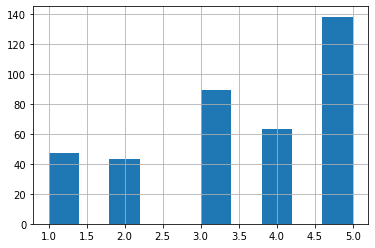

In [363]:
outliers_hist(stud_math_reduced_data,'health')

In [ ]:
#выбросов нет (ни расчетно ни по логике показателя). Пропусков было выявлено 7

In [364]:
#заменим на моду пропуски
mode_null_replace(stud_math_reduced_data, 'health')

In [365]:
#приведем  типу int в соответсвтии со смыслом показателя

stud_math_reduced_data.health=stud_math_reduced_data.health.astype(int)

# 'absences' количество пропущенных занятий

In [347]:
stud_math_reduced_data.absences.unique()


array([  6.,   4.,  10.,   2.,   0.,  16.,  nan,  14.,   7.,   8.,  25.,
        12.,  54.,  18.,  26.,  20.,  56.,  24.,  28.,   5.,  13.,  15.,
        22.,   3., 385.,  21.,   1.,  75.,  30.,  19.,   9.,  11.,  38.,
        40.,  23.,  17., 212.])

In [334]:
stud_math_reduced_data.absences.describe()

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


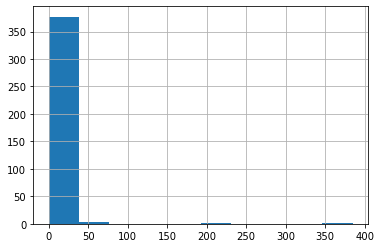

In [335]:
outliers_hist(stud_math_reduced_data,'absences')

In [348]:
stud_math_reduced_data.absences[stud_math_reduced_data.absences>20]

40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64

In [349]:
stud_math_reduced_data.absences.mode()

0    0.0
dtype: float64

In [351]:
#имеются значения, выходящие за пределы рассчитанных границ выбросов. По логике показателя такие значения могут иметь место,
#значение 385 и 212 встречаются единожды и являются эстремально высокими. Заменим их на моду
stud_math_reduced_data.absences.replace(385.0,0.0, inplace=True)
stud_math_reduced_data.absences.replace(212.0,0.0, inplace=True)

In [352]:
stud_math_reduced_data.absences.describe()

count    383.000000
mean       5.720627
std        8.078008
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       75.000000
Name: absences, dtype: float64

In [358]:
#заменим на моду пропуски
mode_null_replace(stud_math_reduced_data, 'absences')

<AxesSubplot:>

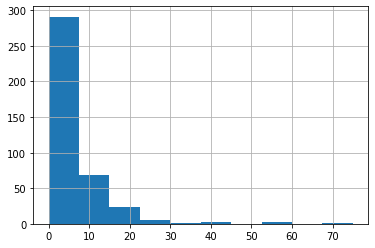

In [359]:
stud_math_reduced_data.absences.hist()
#посмотрим на распределение после удаления выбросов и пустых ячеек

In [366]:
#приведем  типу int в соответствии со смыслом показателя

stud_math_reduced_data.absences = stud_math_reduced_data.absences.astype(int)

# ПРОГНОЗИРУЕМАЯ ВЕЛИЧИНА 'score' баллы по госэкзамену по математике

In [ ]:
#выявлено 6 пропусков данных

In [368]:
stud_math_reduced_data.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan,  20.])

In [395]:
#пропуски в данных прогнозируемой величины заполнять не будем, чтобы не искажать данные. Удалим строки, где отсутсвтуют 
#данные score
str_for_drop = [st for st in stud_math_reduced_data.index if stud_math_reduced_data.loc[st,'score'].astype(str)=='nan']
print (str_for_drop)
stud_math_reduced_score = stud_math_reduced_data.drop(str_for_drop, axis=0)            
stud_math_reduced_score.info()

[201, 244, 270, 283, 312, 350]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school                  389 non-null    object 
 1   sex                     389 non-null    object 
 2   age                     389 non-null    int64  
 3   address                 389 non-null    object 
 4   famsize                 389 non-null    object 
 5   Pstatus                 389 non-null    object 
 6   Medu                    389 non-null    int32  
 7   Fedu                    389 non-null    int32  
 8   Mjob                    389 non-null    object 
 9   Fjob                    389 non-null    object 
 10  reason                  389 non-null    object 
 11  guardian                389 non-null    object 
 12  traveltime              389 non-null    int32  
 13  studytime               389 non-null    int32  
 14  failures   

In [ ]:
# в датасете вычищены пустые значения и выбросы

In [397]:
#приведем  score к типу int в соответствии со смыслом показателя

stud_math_reduced_score.score=stud_math_reduced_score.score.astype(int)

Text(0.5, 1.0, 'Корреляция всех числовых признаков')

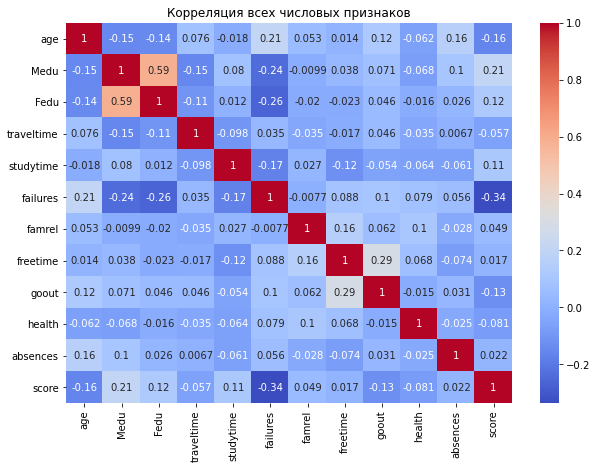

In [405]:
#проанализируем корреляцию между признаками 
correlation = stud_math_reduced_score.loc[:,stud_math_reduced_score.columns[0:29]].corr()
plt.figure(figsize=(10, 7))
sns. heatmap(correlation, annot = True, cmap = 'coolwarm')
plt.title('Корреляция всех числовых признаков')

1. Самая тесная корреляция 0,59 между параметрами образования отца и матери.Но эти параметры в действительности не являются производными друг от друга, удалять один из них как лишний не следует.
2. Самую слабую связь с score имеют продолжительность свободного времени после школы (0,017) и количество пропущенных занятий, при этом связь прямая.
3. Самую тесную связь со score имеют количество внеучебных неудач (-0,34) и возраст (-0,16)
4. Интересной является достаточно сильная связь между уровнем образования родителей и числом внеучебных неудач ребенка.
Можно предположить, что чем выше уровень образования родителей, тем меньше неудач имеет ребенок, т.к. родители способны его лучше подготовить к различным ситуациям, лучше его обучают
При этом связь образования матери с результатом score почти вдвое выше, чем связь уровня образования отца. Видимо, матери больше влияют на ход обучения детей (матери также чаще являются опекунами)
5. Ожидаемой была достаточно тесная связь межу свободным врменем и временем, проведенным с друзьями (0,29)
6.  Все имеющиеся количественные признаки можно использовать для построения модели

In [480]:
#отранжируем параметры по степени корреляции с score
corr_score = stud_math_reduced_score.loc[:,stud_math_reduced_score.columns[0:29]].corr().loc[:,'score'].sort_values()
print(corr_score)

failures     -0.337187
age          -0.155726
goout        -0.127742
health       -0.080583
traveltime   -0.056535
freetime      0.017481
absences      0.021838
famrel        0.048896
studytime     0.114295
Fedu          0.124829
Medu          0.209758
score         1.000000
Name: score, dtype: float64


In [ ]:
#По Чеддоку связь практиески отсутствует при коэффициенте ниже 0,3 по модулю. Т.к. мы рассматриваем множество факторов и 
#зависимость может быть нелинейной сохраним для использования в модели все факторы с корреляциес свыше 0,05

In [516]:
#сформируем список выбранных количественных столбцов для дальнейшей работы
factor_list  = list(corr_score[0.05<corr_score].index) + list(corr_score[corr_score<-0.05].index)


for col in factor_list:
    if col +'_was_missing' in stud_math_reduced_score.columns:
        factor_list.append(col + '_was_missing')#добавим столбцы, где фиксировали замену данных в выбранных признаках  
print(factor_list)


['studytime', 'Fedu', 'Medu', 'score', 'failures', 'age', 'goout', 'health', 'traveltime', 'studytime_was_missing', 'Fedu_was_missing', 'Medu_was_missing', 'failures_was_missing', 'goout_was_missing', 'health_was_missing', 'traveltime_was_missing']


In [ ]:
#Для номинативных переменых можно посмотреть, различаются ли распределения score в зависимости от значения этих переменных.
#Это можно сделать с помощью box-plot

In [467]:
def get_boxplot(column):#функция для вывода ящичных диаграмм распределения Score в зависимости 
                        #от значения каждой из переменных
    fig, ax = plt.subplots(figsize = (8, 3))
    sns.boxplot(x=column, y='score', 
                data=stud_math_reduced_score.loc[stud_math_reduced_score.loc[:, column].
                isin(stud_math_reduced_score.loc[:, column].value_counts().index)],                      
               ax=ax)
    plt.xticks()
    ax.set_title('Boxplot for ' + column)
    plt.show()

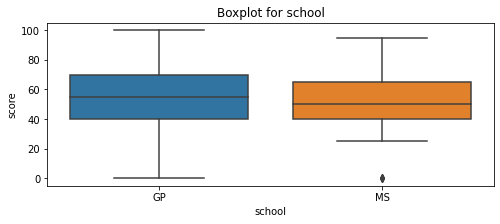

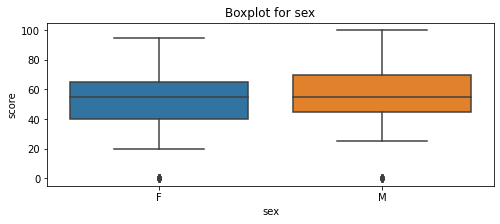

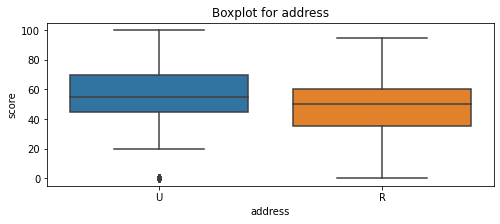

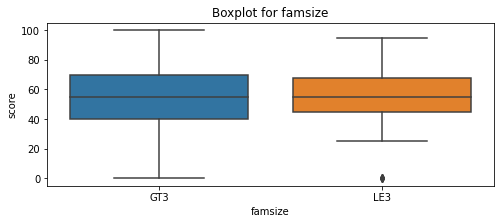

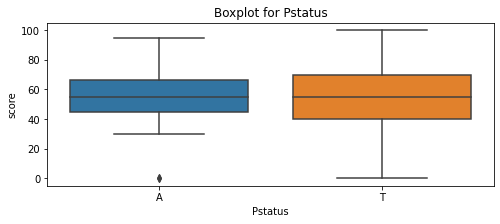

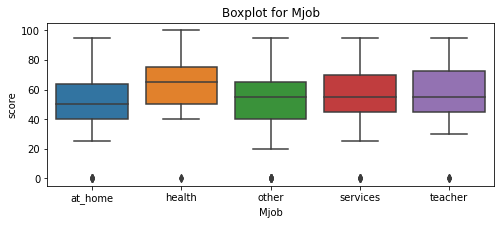

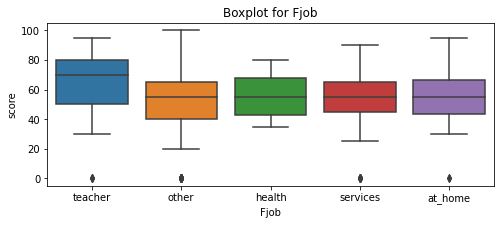

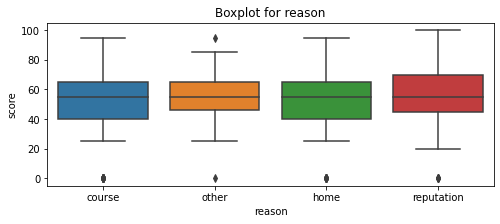

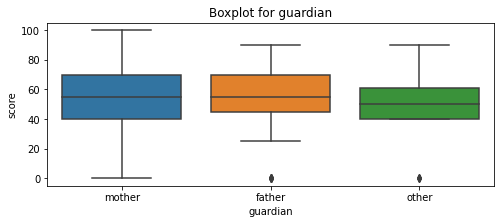

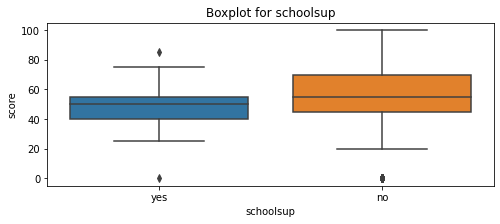

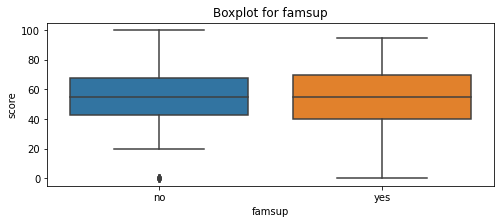

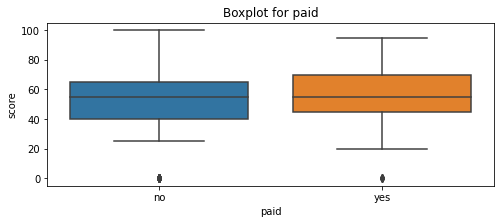

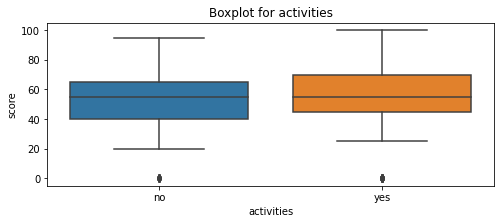

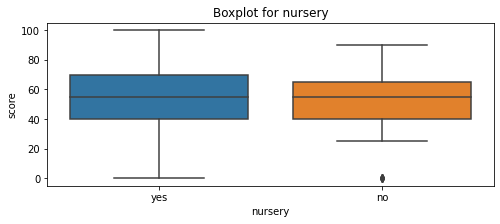

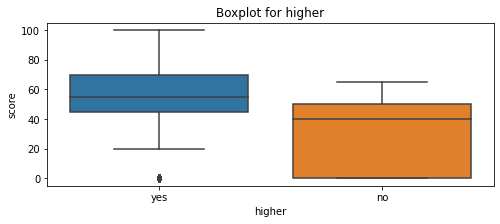

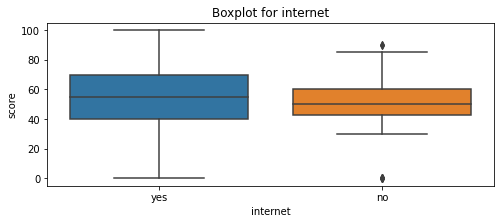

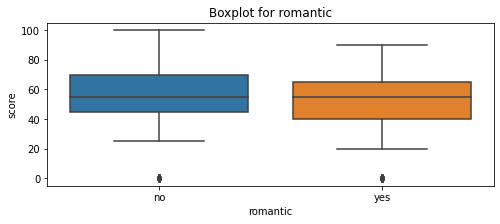

In [468]:
#сформируем список номинативных переменных
list_object_data = [col for col in stud_math_reduced_score.columns if  stud_math_reduced_score.dtypes.loc[col]=='O']

#построим диаграммы для каждой из переменных в списке
for column in list_object_data:
    get_boxplot(column)

По графикам визуально можно выделить, что слабое влияние на распределение score оказывает размер семьи (famsize), наличие внеучебных занятий (activities) и романтиеских отношений (romantic).
Чтобы отобрать статистически значимые признаки с помощью теста Стьюдента проверим нулевую гипотезу о том, что распределения количества баллов за госэкзамен не различаются по различным параметрам.

In [502]:
def get_stat_dif(column):# функция для определения статистической значимости различия распределения score при разных
                         #значениях расматриваемого параметра (значимые - те, для которых нулевая гипотеза не верна)
    
    
    cols = stud_math_reduced_score.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    
    
    for comb in combinations_all:
        if ttest_ind(stud_math_reduced_score.loc[stud_math_reduced_score.loc[:, column] == comb[0], 'score'], 
                    stud_math_reduced_score.loc[stud_math_reduced_score.loc[:, column] == comb[1], 'score']).pvalue \
                    <= 0.05/len(combinations_all): # Учли поправку Бонферони
            
            print('Найдены статистически значимые различия для колонки', column)
            factor_list.append(column)#добавили значимый фактор в список столбцов для дальнейшей работы
            
            break

In [517]:
#проверим на наличие значимых различий score в зависимости от значений признака для всех признаков номенативного типа
for col in list_object_data:
    get_stat_dif(col)

    
print('Общий список столбцов для дальнейшего использования', factor_list )

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Общий список столбцов для дальнейшего использования ['studytime', 'Fedu', 'Medu', 'score', 'failures', 'age', 'goout', 'health', 'traveltime', 'studytime_was_missing', 'Fedu_was_missing', 'Medu_was_missing', 'failures_was_missing', 'goout_was_missing', 'health_was_missing', 'traveltime_was_missing', 'address', 'Mjob', 'higher', 'romantic']


In [519]:
#в новый датафрейм пренесем отобранные числовые и номенативны переменые, очищенные от выбросов и пропусков значений
stud_math_to_use = stud_math_reduced_score[factor_list]
stud_math_to_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   studytime               389 non-null    int32 
 1   Fedu                    389 non-null    int32 
 2   Medu                    389 non-null    int32 
 3   score                   389 non-null    int32 
 4   failures                389 non-null    int32 
 5   age                     389 non-null    int64 
 6   goout                   389 non-null    int32 
 7   health                  389 non-null    int32 
 8   traveltime              389 non-null    int32 
 9   studytime_was_missing   389 non-null    bool  
 10  Fedu_was_missing        389 non-null    bool  
 11  Medu_was_missing        389 non-null    bool  
 12  failures_was_missing    389 non-null    bool  
 13  goout_was_missing       389 non-null    bool  
 14  health_was_missing      389 non-null    bool  
 15  travel

В итоге обработки мы отобрали 12 влияющих параметров, 8 из которых числовые, 4 номенативные.
Создали 7 вспомогательных столбцов для сохранения понимания, в каких строках заменяли пустые значения (возможно это пригодится в будущем).
Из имевшихся 395 строк датасета сохранили для работы 389, не прибегая к удалению строк с пустыми значениями из-за малого размера выборки, а заменяя их на медиану или моду (большинство столбцов содержало пропуски). Пропуски удалены только в прогнозируемой переменной score.
Данные приведены к удобному формату и подготовлены для дальнешего использования.